# Introduction

In [21]:
#Reset kernel when start this notebook
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
import time

In [61]:
def create_spark_session(number_threads):
    #local[*] -> Number of threads
    spark = SparkSession.builder.master(f'local[{number_threads}]').getOrCreate()
    
    sc = spark.sparkContext
    print("spark session obtained!")
    return spark

In [40]:
def stop_spark_session(session):
    session.stop()
    print("Spark session stopped")

In [42]:
spark_session = create_spark_session(3)
print(spark_session.sparkContext.defaultParallelism)
print(spark_session.version)

3
3.5.0


In [53]:
stop_spark_session(spark_session)

Spark session stopped


In [12]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 6.6 gigabytes of available RAM



In [5]:
# Packages for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter

In [27]:
spark = SparkSession.builder.master("local[5]").appName("SparkByExamples.com").getOrCreate()

df = spark.range(0,20)
df2 = df.repartition(6)
print(df2.rdd.getNumPartitions())

#df.write.mode(SaveMode.Overwrite)csv("partition.csv")

6


# Data Analysis

* As Spark Dataframes operations are lazy, we need to use show() to trigger the computation and see the results

Data dictionary of this dataset can be found in the following link:
https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

In [44]:
sdf = spark_session.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("dataset/yellow_tripdata_2017-01.parquet")
#sdf = sdf.repartition(6)

In [52]:
def read_parquet_file(spark_session, path, partitions):
    sdf = spark_session.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("dataset/yellow_tripdata_2017-01.parquet")
    if partitions is not None:
        sdf = sdf.repartition(partitions)
    return sdf

In [71]:
spark_session = create_spark_session('*')
sdf = read_parquet_file(spark_session,"dataset/yellow_tripdata_2017-01.parquet", 9)
print(f'File read. Number of partitions {sdf.rdd.getNumPartitions()}')

spark session obtained!
File read. Number of partitions 9


In [70]:
stop_spark_session(spark_session)

Spark session stopped


In [7]:
#Check the type of data of each column
sdf.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: integer (nullable = true)
 |-- airport_fee: integer (nullable = true)



In [6]:
#See the number of records
sdf.count()

9710820

## Null values

In [19]:
from pyspark.sql.functions import col, sum, when, expr

In [20]:
# Create a list of expressions that count null values for each column
null_counts = [sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in sdf.columns]

# Apply the expressions to the DataFrame and display the result
# The '*' is used to unpack the list and pass each expression as separete arg
# The agg funciton is to apply the expressions to the dataframe 'sdf'
sdf.agg(*null_counts).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|              0|            0|         0|                 0|           0|           0|           0|          0|    0|      0|         

In [21]:
#The 'congestion_surcharge' and 'airport_fee' columns are null, let's remove them
sdf = sdf.drop(*["congestion_surcharge","airport_fee"])

Null Values by RDD

Null Values by DataFrame

Null Values by SQL

## Take a sample from the dataset
Select a set of records randomly to limit the size of the dataset, thus executing operations easier

In [11]:
#Opcional para reducir los datos
sdf = sdf.sample(withReplacement=False, fraction=0.5, seed=15)
new_size = sdf.count()
print(f"Size of the sample '{new_size}'")

Size of the sample '4856845'


# Estudio #1 -  Las rutas mas frecuentes

In [22]:
df_filtered = sdf[["PULocationID","DOLocationID","trip_distance","tolls_amount","total_amount"]]

In [23]:
sdf_zones = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("dataset/taxi_zone_lookup.csv")
sdf_zones.show()

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

In [24]:
# Crossing data to know more about the locations both pickup and dropoff
df_crossdata = df_filtered.join(sdf_zones, col("LocationID") == col("PULocationID"))
df_crossdata.show()

+------------+------------+-------------+------------+------------+----------+---------+--------------------+------------+
|PULocationID|DOLocationID|trip_distance|tolls_amount|total_amount|LocationID|  Borough|                Zone|service_zone|
+------------+------------+-------------+------------+------------+----------+---------+--------------------+------------+
|         140|         236|          1.2|         0.0|         7.8|       140|Manhattan|     Lenox Hill East| Yellow Zone|
|         237|         140|          0.7|         0.0|         6.3|       237|Manhattan|Upper East Side S...| Yellow Zone|
|         140|         237|          0.8|         0.0|         6.8|       140|Manhattan|     Lenox Hill East| Yellow Zone|
|          41|          42|          1.1|         0.0|         7.3|        41|Manhattan|      Central Harlem|   Boro Zone|
|          48|         263|          3.0|         0.0|        12.3|        48|Manhattan|        Clinton East| Yellow Zone|
|         236|  

In [25]:
df_crossdata = df_crossdata.withColumnRenamed("Borough","borough_pickup")
df_crossdata = df_crossdata.withColumnRenamed("Zone","zone_pickup")
df_crossdata = df_crossdata.withColumnRenamed("service_zone","service_pickup")

In [26]:
df_crossdata.show()

+------------+------------+-------------+------------+------------+----------+--------------+--------------------+--------------+
|PULocationID|DOLocationID|trip_distance|tolls_amount|total_amount|LocationID|borough_pickup|         zone_pickup|service_pickup|
+------------+------------+-------------+------------+------------+----------+--------------+--------------------+--------------+
|         140|         236|          1.2|         0.0|         7.8|       140|     Manhattan|     Lenox Hill East|   Yellow Zone|
|         237|         140|          0.7|         0.0|         6.3|       237|     Manhattan|Upper East Side S...|   Yellow Zone|
|         140|         237|          0.8|         0.0|         6.8|       140|     Manhattan|     Lenox Hill East|   Yellow Zone|
|          41|          42|          1.1|         0.0|         7.3|        41|     Manhattan|      Central Harlem|     Boro Zone|
|          48|         263|          3.0|         0.0|        12.3|        48|     Manhatt

In [27]:
df_crossdata = df_crossdata.drop("LocationID")

In [28]:
df_crossdata = df_crossdata.join(sdf_zones, col("LocationID") == col("DOLocationID"))
df_crossdata = df_crossdata.withColumnRenamed("Borough","borough_dropoff")
df_crossdata = df_crossdata.withColumnRenamed("Zone","zone_dropoff")
df_crossdata = df_crossdata.withColumnRenamed("service_zone","service_dropoff")
df_crossdata.show()

+------------+------------+-------------+------------+------------+--------------+--------------------+--------------+----------+---------------+--------------------+---------------+
|PULocationID|DOLocationID|trip_distance|tolls_amount|total_amount|borough_pickup|         zone_pickup|service_pickup|LocationID|borough_dropoff|        zone_dropoff|service_dropoff|
+------------+------------+-------------+------------+------------+--------------+--------------------+--------------+----------+---------------+--------------------+---------------+
|         140|         236|          1.2|         0.0|         7.8|     Manhattan|     Lenox Hill East|   Yellow Zone|       236|      Manhattan|Upper East Side N...|    Yellow Zone|
|         237|         140|          0.7|         0.0|         6.3|     Manhattan|Upper East Side S...|   Yellow Zone|       140|      Manhattan|     Lenox Hill East|    Yellow Zone|
|         140|         237|          0.8|         0.0|         6.8|     Manhattan|   

In [29]:
from pyspark.sql import functions as F

In [30]:
#Now with this information, we can group the routes based on the pickup and drop off area.
grouped_sdf = df_crossdata.groupBy("borough_pickup", "borough_dropoff").agg(F.count("total_amount").alias("total_trips"))

In [31]:
grouped_sdf = grouped_sdf.orderBy(col("total_trips").desc())
grouped_sdf.show()

+--------------+---------------+-----------+
|borough_pickup|borough_dropoff|total_trips|
+--------------+---------------+-----------+
|     Manhattan|      Manhattan|    8209134|
|        Queens|      Manhattan|     297952|
|     Manhattan|         Queens|     291300|
|     Manhattan|       Brooklyn|     281317|
|        Queens|         Queens|     148161|
|       Unknown|        Unknown|     145607|
|      Brooklyn|       Brooklyn|      89365|
|        Queens|       Brooklyn|      75518|
|     Manhattan|          Bronx|      42230|
|      Brooklyn|      Manhattan|      35845|
|       Unknown|      Manhattan|      20018|
|     Manhattan|        Unknown|      17656|
|     Manhattan|            EWR|      14390|
|        Queens|        Unknown|       9636|
|        Queens|          Bronx|       8766|
|      Brooklyn|         Queens|       7317|
|         Bronx|          Bronx|       5154|
|       Unknown|         Queens|       2685|
|         Bronx|      Manhattan|       2222|
|     Manh

This table shows the top 20 of the most frequent routes registered in January, 2017. Trips in manhattan place the first position, and appear multiple times either as pickup or drop off zone.

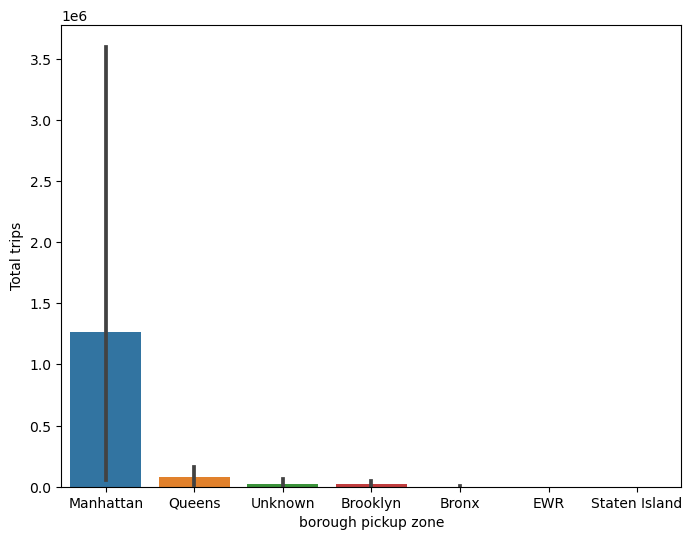

In [32]:
plt.figure(figsize=(8, 6))
result_df_p = grouped_sdf.toPandas()
barplot = sns.barplot(data=result_df_p, x="borough_pickup", y="total_trips")
plt.xlabel("borough pickup zone")
plt.ylabel("Total trips")

# Show the plot
plt.show()

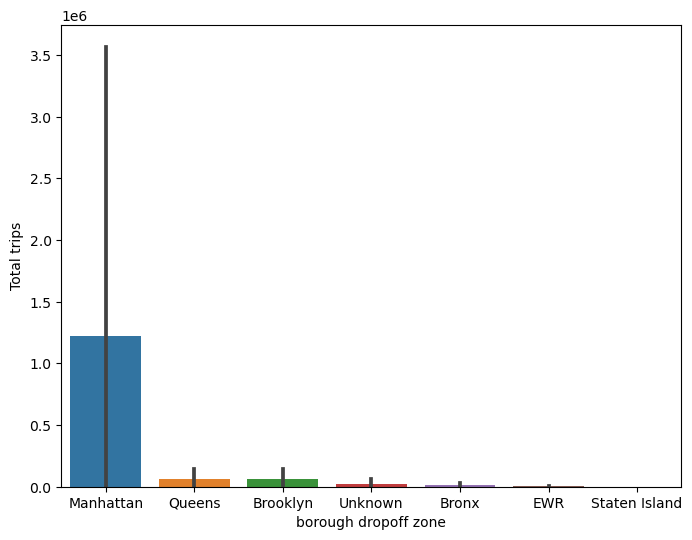

In [33]:
plt.figure(figsize=(8, 6))
result_df_p = grouped_sdf.toPandas()
barplot = sns.barplot(data=result_df_p, x="borough_dropoff", y="total_trips")
plt.xlabel("borough dropoff zone")
plt.ylabel("Total trips")

# Show the plot
plt.show()

# Estudio #2 - Las rutas que mas dinero generaron

Based in the analysis made in the previous section, we can calculate routes that earned the most money

In [69]:
grouped_sdf = df_crossdata.groupBy("borough_pickup", "borough_dropoff").agg(F.sum("total_amount").alias("total_amount"))
#Let's divide the total_amount by 1000 for better visualization
grouped_sdf = grouped_sdf.withColumn("total_amount", col("total_amount") / 100000)
grouped_sdf = grouped_sdf.orderBy(col("total_amount").desc())
grouped_sdf.show()

+--------------+---------------+-------------------+
|borough_pickup|borough_dropoff|       total_amount|
+--------------+---------------+-------------------+
|     Manhattan|      Manhattan|  495.2335873876105|
|        Queens|      Manhattan|  77.54298089991384|
|     Manhattan|         Queens|  58.20980129992354|
|     Manhattan|       Brooklyn| 37.721182499960534|
|        Queens|       Brooklyn|  17.48376460000649|
|        Queens|         Queens| 15.711661100015158|
|       Unknown|        Unknown| 12.829985200009316|
|     Manhattan|            EWR|  6.854274300000129|
|     Manhattan|          Bronx|  6.460794400000298|
|      Brooklyn|       Brooklyn| 5.5146233999985155|
|      Brooklyn|      Manhattan|  4.111471999999369|
|        Queens|        Unknown|  4.055924299999893|
|     Manhattan|        Unknown|  3.719848499999613|
|        Queens|          Bronx|  2.360619199999907|
|       Unknown|      Manhattan| 1.6638833999999587|
|      Brooklyn|         Queens| 1.04653150000

As we can see, the the routes that started and finished in manhattan were the ones that earned the most money. Next, queens to manhattan and, in the third place, manhattan to queens.

# Estudio #3 - 

# Estudio #4 - Taxi Velocity average in each hour

## DATAFRAME

### Dataframe operations compressed for performance comparation

In [78]:
#Operations reduced
from pyspark.sql.functions import hour, udf, avg, col
from pyspark.sql.types import IntegerType, StringType

#convert to seconds manually through User defined functions (UDF)
def interval_to_seconds(interval):
    total_seconds = interval.total_seconds()
    return int(total_seconds)

interval_to_seconds_udf = udf(interval_to_seconds, IntegerType())

# START THE TIMER
DFstarttime = time.time()
sdfDF = sdf.withColumn("duration", col("tpep_dropoff_datetime")-col("tpep_pickup_datetime"))
sdfDF = sdfDF.withColumn("duration", (interval_to_seconds_udf(col("duration")) / 3600))
sdfDF = sdfDF.filter(col("duration") > 0)
sdfDF = sdfDF.withColumn("velocity",col("trip_distance")/col("duration"))
sdfDF = sdfDF.withColumn("hour_pickup", hour(col("tpep_pickup_datetime")))
sdfDF = sdfDF.withColumn("hour_dropoff", hour(col("tpep_dropoff_datetime")))

result_df = sdfDF.groupBy("hour_pickup").agg(avg("velocity").alias("VelocityAvg")).orderBy("hour_pickup")
result_df.show(24)
#STOP TIMER
DFendtime = time.time()

+-----------+------------------+
|hour_pickup|       VelocityAvg|
+-----------+------------------+
|          0|17.135377162085373|
|          1|  17.7084494704235|
|          2|18.005655850937046|
|          3|18.156252751944653|
|          4| 20.76540968125122|
|          5| 22.53105310024046|
|          6|18.062101710891028|
|          7|13.693853937236215|
|          8|11.674041169497219|
|          9|11.739438524116354|
|         10| 12.19164877672022|
|         11|11.970101055787831|
|         12|12.047918921365886|
|         13|12.541032414917348|
|         14|11.874196223496451|
|         15|11.606618169769838|
|         16|12.391826175756417|
|         17|11.713800892106143|
|         18| 11.60556837151269|
|         19|12.547998876114262|
|         20|13.913271912840372|
|         21|  15.1267632937441|
|         22|15.818566971052546|
|         23|17.170343696303483|
+-----------+------------------+



In [79]:
ExecTime = DFendtime - DFstarttime 
print(ExecTime)

45.459200859069824


## Analysis with Dataframe

In [ ]:
#Let's calculate the difference of time between the pick-up and the drop-off
sdf = sdf.withColumn("duration", col("tpep_dropoff_datetime")-col("tpep_pickup_datetime"))
sdf.select("duration").show()

### Check duration of trips

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, StringType


#convert to seconds manually through User defined functions (UDF)
def interval_to_seconds(interval):
    total_seconds = interval.total_seconds()
    return int(total_seconds)

interval_to_seconds_udf = udf(interval_to_seconds, IntegerType())

In [ ]:
# Use the UDF to extract seconds and store in a new column
sdf = sdf.withColumn("duration", interval_to_seconds_udf(col("duration")))

# Show the DataFrame with the extracted seconds
sdf.select("duration").show()

In [ ]:
#Let's check for some anomalities in this column
sdf.filter(col("duration") < 0).show()

In [ ]:
sdf.filter(col("duration") == 0).show()

All the above records shows that all the trips where finished at the same time when started.

Because of all these records, we proceed to remove them

In [ ]:
sdf = sdf.filter(col("duration") > 0)
size_after_reduction = sdf.count()
print(f"Size of the sample '{size_after_reduction}'")

### Calculate Velocity of each trip

In [ ]:
#As the duration column is in seconds, we have to divide the value between 3600 to the value in hour units.
sdf = sdf.withColumn("velocity",col("trip_distance")/(col("duration")/3600))
sdf.select("velocity").show()

*The units of these values are miles per hour

### Calculate avg per hour

In [ ]:
from pyspark.sql.functions import hour

In [ ]:
sdf = sdf.withColumn("hour_pickup", hour(col("tpep_pickup_datetime")))
sdf = sdf.withColumn("hour_dropoff", hour(col("tpep_dropoff_datetime")))
sdf.show()

In [ ]:
from pyspark.sql.functions import avg, max, min

In [ ]:
result_df = sdf.groupBy("hour_pickup").agg(avg("velocity").alias("VelocityAvg")).orderBy("hour_pickup")

# Show the resulting DataFrame
result_df.show(24)

### Visualize results

In [ ]:
plt.figure(figsize=(10, 6))
result_df_p = result_df.toPandas()
barplot = sns.barplot(data=result_df_p, x="hour_pickup", y="VelocityAvg")
plt.xlabel("Hour")
plt.ylabel("Average velocity")

# Show the plot
plt.show()

## RDD

In [80]:
RDDstarttime = time.time()

In [81]:
# Filtra las columnas que tengan campos Nulls y filtra filas que tengan tiempos Cero entre la diferencia de Llegada y Recogida
filtered = sdf.rdd.filter(lambda x: x[1] is not None and x[2] is not None and x[4] is not None).filter(lambda x: (x[2] - x[1]).seconds > 0)

In [82]:
# Hace un mapeo de la hora recogida, la velocidad en la hora y un contador
mapped = filtered.map(lambda x: (x[1].hour, (x[4]/(((x[2] - x[1]).seconds)/3600), 1)))

In [83]:
# Realiza el Reduce en Referencia a la hora y Sumando Contador y Velocidades
result = mapped.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

In [84]:
# Obtiene los promedios de las velocidades por hora y los muestra en pantalla
result.map(lambda x: (x[0], x[1][0] / x[1][1] )).sortBy(lambda x: x[0], True).take(24)

[(0, 17.135377162085373),
 (1, 17.7084494704235),
 (2, 18.005655850937046),
 (3, 18.156252751944653),
 (4, 20.76540968125122),
 (5, 22.53105310024046),
 (6, 18.062101710891028),
 (7, 13.693853937236215),
 (8, 11.674041169497219),
 (9, 11.739438524116354),
 (10, 12.19164877672022),
 (11, 11.970101055787831),
 (12, 12.047918921365886),
 (13, 12.541032414917348),
 (14, 11.874196223496451),
 (15, 11.60659330518431),
 (16, 12.391826175756417),
 (17, 11.713800892106143),
 (18, 11.605549669453614),
 (19, 12.547998876114262),
 (20, 13.913271912840372),
 (21, 15.1267632937441),
 (22, 15.818566971052546),
 (23, 17.170343696303483)]

In [85]:
RDDendtime = time.time()

#SPEEDUP RDD

In [86]:
ExecTime = RDDendtime - RDDstarttime 
print(ExecTime)

108.49324607849121


## SQL

In [90]:
SQLstarttime = time.time()
#Los datos leídos los sube a memoria en una tabla temporal
sdf.createOrReplaceTempView('tabledataset')

In [91]:
#Let's calculate the difference of time between the pick-up and the drop-off in seconds
#Difference DateTime
#Velocity
#Hour from tpep_pickup_datetime
#Hour from tpep_dropoff_datetime
# In Where filter Values dropoff>pickup
dfsqlreduce = spark.sql("""SELECT *,
                                (unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime)) AS difference_datetime,
                                trip_distance/(( (unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime))/60 )/60) AS velocity,
                                HOUR(tpep_pickup_datetime) AS pickup_hour,
                                HOUR(tpep_dropoff_datetime) AS dropoff_hour
                            FROM tabledataset
                            WHERE tpep_dropoff_datetime > tpep_pickup_datetime
                        """) 

In [92]:
#Calculate the velocity avg of each hour
#dfsqlreduce_avg = dfsqlreduce
dfsqlreduce.createOrReplaceTempView('tabledataset2')
dfsqlreduce_avg = spark.sql("""SELECT 
                                pickup_hour,
                                sum(velocity) as sumvelocity,
                                count(velocity) as countvelocity,
                                avg(velocity) as hourly_average        
                            FROM tabledataset2
                            GROUP BY pickup_hour
                            ORDER BY pickup_hour ASC
                            """) 
dfsqlreduce_avg.show(24)
SQLendtime = time.time()

+-----------+------------------+-------------+------------------+
|pickup_hour|       sumvelocity|countvelocity|    hourly_average|
+-----------+------------------+-------------+------------------+
|          0| 5414162.309641142|       315964|17.135377162085373|
|          1|  4270126.96305057|       241135|  17.7084494704235|
|          2| 3377608.958453877|       187586|18.005655850937046|
|          3|  2518798.78802453|       138729|18.156252751944653|
|          4|2196336.6165762604|       105769| 20.76540968125122|
|          5|  2320946.31090887|       103011| 22.53105310024046|
|          6| 3970573.757003464|       219829|18.062101710891028|
|          7|  5089813.79451558|       371686|13.693853937236215|
|          8| 5291352.552403971|       453258|11.674041169497219|
|          9| 5289697.083458636|       450592|11.739438524116354|
|         10| 5320581.825946025|       436412| 12.19164877672022|
|         11| 5470946.657648884|       457051|11.970101055787831|
|         

In [93]:
ExecTime = SQLendtime - SQLstarttime 
print(ExecTime)

6.2073540687561035


In [45]:
#SpeedUp SQL

# Analisis de rendimiento